# Reinforcement Learning Notebook - Get expert trajectories - Cartpole-v0

##### In this notebook we aim at saving several expert trajectories one by one whith different length of the pendulum and then use them as the expert trajectories

In [2]:
import gym
import numpy as np
import cvxpy as cp
import sys
import pylab
import pandas as pd 
import torch
from torch.autograd import Variable
import copy
import torch.nn.functional as F
import random
import torch.nn as nn
import math
from itertools import count
from PIL import Image
import torch
import torch.optim 
import torchvision.transforms as transforms
from collections import namedtuple, deque
from torch import nn
from gym import make
import torch.optim as optim
from numpy import save
from tqdm.notebook import tqdm
import pickle
from typing import Optional
import IPython
from IPython.display import set_matplotlib_formats; set_matplotlib_formats('svg')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import os
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
from Code.utils import Net, Agent, Memory
from Code.plotting import preprocess_states, animate

### DQN - Save expert trajectories

In [3]:
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

In [27]:
def main(environment, length):

    env = gym.make(environment)
    env.env.length = length 

    action_dim = env.action_space.n
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    agent = Agent(input_dim, output_dim, action_dim, environment)

    training_records = []
    running_reward, running_q = -1000, 0

    full_trajs = [] #supposed to be a list of arrays that will save several expert traj
    episodes = 350
    
    action_list = [i for i in range(action_dim)]
    
    for i_ep in tqdm(range(episodes)):
        score = 0
        
        #We fix the departure state 
#        state = env.reset()
#        env.env.state = np.array([np.pi/2, 0.5])
#        env.env.last_u = None
#        state = env.env._get_obs()
        
        #to make it more robust we have to use :
        #state = env.reset()
        
        state = env.reset()
        state = np.array([-6.18010447e+00, -5.22830905e+00,  7.34760972e+00,
         5.29961320e+00]) #fix the firs state
        
        
        
        full_traj = state.reshape(1,-1)
        for t in range(1, 200):
            action, action_index = agent.select_action(state)
            
            action = action_list[action_index]
            
            
            state_, reward, done, _ = env.step(action)
            full_traj = np.concatenate((full_traj, np.array(state_).reshape(1,-1)))
            score += reward

            env.render()
            agent.store_transition(Transition(state, action_index, (reward + 8) / 8, state_))
            state = state_
            if agent.memory.isfull:
                q = agent.update()
                running_q = 0.99 * running_q + 0.01 * q

        running_reward = running_reward * 0.9 + score * 0.1
        training_records.append(TrainingRecord(i_ep, running_reward))

        print('Ep', i_ep, 'Average score:', running_reward, 'score of current env', score )
        
        if i_ep > episodes - 3:
            full_trajs.append(full_traj)


    agent.save_param()
    with open('/Users/ilanasebag/Documents/Thesis_Code/RL_results/dqn_training_records_%s_length%s.pkl'%(environment,length), 'wb') as f:
        pickle.dump(training_records, f)
        
    save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_l%s_exp_states_%s.npy'%(length,environment),full_trajs[-1])       
    #save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_exp_states_%s.npy'%environment,full_trajs[-1])
    #save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/multi_exp_states_%s.npy'%environment,full_trajs)

    env.close()

    plt.plot([r.ep for r in training_records], [r.reward for r in training_records], color = 'grey')
    plt.xlabel('Episode')
    plt.ylabel('Moving averaged reward')
    plt.savefig("/Users/ilanasebag/Documents/Thesis_Code/RL_results/dqn_%s_length%s.png"%(environment,length))
    plt.show()


Ep 0 Average score: -892.5 score of current env 75.0
Ep 1 Average score: -800.05 score of current env 32.0
Ep 2 Average score: -717.045 score of current env 30.0
Ep 3 Average score: -643.1405 score of current env 22.0
Ep 4 Average score: -574.5264500000001 score of current env 43.0
Ep 5 Average score: -514.6738050000001 score of current env 24.0
Ep 6 Average score: -459.1064245000001 score of current env 41.0
Ep 7 Average score: -409.6957820500001 score of current env 35.0
Ep 8 Average score: -362.5262038450001 score of current env 62.0
Ep 9 Average score: -321.87358346050013 score of current env 44.0
Ep 10 Average score: -287.8862251144501 score of current env 18.0
Ep 11 Average score: -257.3976026030051 score of current env 17.0
Ep 12 Average score: -229.7578423427046 score of current env 19.0
Ep 13 Average score: -203.98205810843413 score of current env 28.0
Ep 14 Average score: -182.0838522975907 score of current env 15.0
Ep 15 Average score: -161.67546706783165 score of current en

Ep 125 Average score: 175.71831839678347 score of current env 158.0
Ep 126 Average score: 171.34648655710512 score of current env 132.0
Ep 127 Average score: 171.9118379013946 score of current env 177.0
Ep 128 Average score: 171.82065411125512 score of current env 171.0
Ep 129 Average score: 170.8385887001296 score of current env 162.0
Ep 130 Average score: 172.85472983011664 score of current env 191.0
Ep 131 Average score: 172.66925684710498 score of current env 171.0
Ep 132 Average score: 171.9023311623945 score of current env 165.0
Ep 133 Average score: 174.61209804615504 score of current env 199.0
Ep 134 Average score: 176.35088824153956 score of current env 192.0
Ep 135 Average score: 177.4157994173856 score of current env 187.0
Ep 136 Average score: 179.57421947564706 score of current env 199.0
Ep 137 Average score: 172.11679752808234 score of current env 105.0
Ep 138 Average score: 172.70511777527412 score of current env 178.0
Ep 139 Average score: 163.3346059977467 score of cur

Ep 247 Average score: 134.9661911078112 score of current env 199.0
Ep 248 Average score: 128.36957199703008 score of current env 69.0
Ep 249 Average score: 135.43261479732706 score of current env 199.0
Ep 250 Average score: 141.78935331759436 score of current env 199.0
Ep 251 Average score: 147.51041798583492 score of current env 199.0
Ep 252 Average score: 152.65937618725144 score of current env 199.0
Ep 253 Average score: 157.2934385685263 score of current env 199.0
Ep 254 Average score: 161.46409471167368 score of current env 199.0
Ep 255 Average score: 165.2176852405063 score of current env 199.0
Ep 256 Average score: 168.5959167164557 score of current env 199.0
Ep 257 Average score: 171.63632504481012 score of current env 199.0
Ep 258 Average score: 162.57269254032911 score of current env 81.0
Ep 259 Average score: 166.21542328629621 score of current env 199.0
Ep 260 Average score: 169.4938809576666 score of current env 199.0
Ep 261 Average score: 172.44449286189993 score of curre

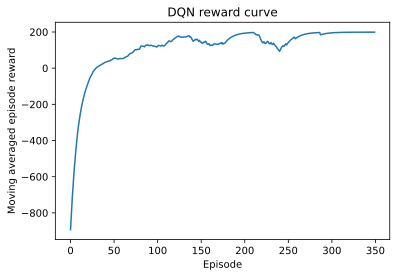

In [53]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    main(environment, 1.2)

Ep 0 Average score: -894.4 score of current env 56.0
Ep 1 Average score: -803.5600000000001 score of current env 14.0
Ep 2 Average score: -721.9040000000001 score of current env 13.0
Ep 3 Average score: -648.1136000000001 score of current env 16.0
Ep 4 Average score: -582.10224 score of current env 12.0
Ep 5 Average score: -523.0920160000001 score of current env 8.0
Ep 6 Average score: -465.98281440000005 score of current env 48.0
Ep 7 Average score: -417.78453296000004 score of current env 16.0
Ep 8 Average score: -372.80607966400004 score of current env 32.0
Ep 9 Average score: -330.9254716976 score of current env 46.0
Ep 10 Average score: -296.53292452784 score of current env 13.0
Ep 11 Average score: -265.679632075056 score of current env 12.0
Ep 12 Average score: -238.01166886755044 score of current env 11.0
Ep 13 Average score: -211.9105019807954 score of current env 23.0
Ep 14 Average score: -188.0194517827159 score of current env 27.0
Ep 15 Average score: -166.3175066044443 sco

Ep 124 Average score: 166.94115338725155 score of current env 199.0
Ep 125 Average score: 161.54703804852642 score of current env 113.0
Ep 126 Average score: 165.2923342436738 score of current env 199.0
Ep 127 Average score: 168.66310081930644 score of current env 199.0
Ep 128 Average score: 171.6967907373758 score of current env 199.0
Ep 129 Average score: 174.42711166363824 score of current env 199.0
Ep 130 Average score: 176.88440049727444 score of current env 199.0
Ep 131 Average score: 179.09596044754701 score of current env 199.0
Ep 132 Average score: 169.58636440279233 score of current env 84.0
Ep 133 Average score: 164.1277279625131 score of current env 115.0
Ep 134 Average score: 167.61495516626178 score of current env 199.0
Ep 135 Average score: 157.05345964963558 score of current env 62.0
Ep 136 Average score: 161.24811368467203 score of current env 199.0
Ep 137 Average score: 165.02330231620485 score of current env 199.0
Ep 138 Average score: 158.62097208458437 score of cur

Ep 246 Average score: 196.8292238139673 score of current env 199.0
Ep 247 Average score: 197.04630143257057 score of current env 199.0
Ep 248 Average score: 197.24167128931353 score of current env 199.0
Ep 249 Average score: 197.41750416038218 score of current env 199.0
Ep 250 Average score: 183.07575374434398 score of current env 54.0
Ep 251 Average score: 168.76817836990958 score of current env 40.0
Ep 252 Average score: 171.79136053291862 score of current env 199.0
Ep 253 Average score: 170.31222447962674 score of current env 157.0
Ep 254 Average score: 173.18100203166406 score of current env 199.0
Ep 255 Average score: 175.76290182849766 score of current env 199.0
Ep 256 Average score: 178.0866116456479 score of current env 199.0
Ep 257 Average score: 172.4779504810831 score of current env 122.0
Ep 258 Average score: 175.1301554329748 score of current env 199.0
Ep 259 Average score: 171.5171398896773 score of current env 139.0
Ep 260 Average score: 168.1654259007096 score of curren

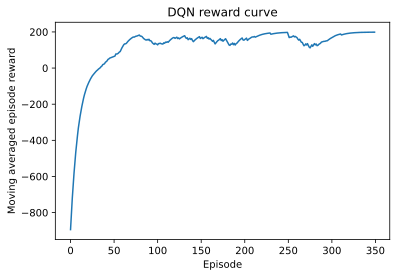

In [48]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    main(environment, 0.5)

Ep 0 Average score: -897.5 score of current env 25.0
Ep 1 Average score: -803.55 score of current env 42.0
Ep 2 Average score: -720.4949999999999 score of current env 27.0
Ep 3 Average score: -644.0455 score of current env 44.0
Ep 4 Average score: -576.84095 score of current env 28.0
Ep 5 Average score: -513.956855 score of current env 52.0
Ep 6 Average score: -460.3611695 score of current env 22.0
Ep 7 Average score: -412.12505255 score of current env 22.0
Ep 8 Average score: -367.71254729500004 score of current env 32.0
Ep 9 Average score: -327.74129256550003 score of current env 32.0
Ep 10 Average score: -292.86716330895 score of current env 21.0
Ep 11 Average score: -261.68044697805504 score of current env 19.0
Ep 12 Average score: -234.01240228024955 score of current env 15.0
Ep 13 Average score: -209.21116205222458 score of current env 14.0
Ep 14 Average score: -186.59004584700213 score of current env 17.0
Ep 15 Average score: -166.53104126230193 score of current env 14.0
Ep 16 A

Ep 125 Average score: 146.13536244246026 score of current env 83.0
Ep 126 Average score: 145.12182619821422 score of current env 136.0
Ep 127 Average score: 143.5096435783928 score of current env 129.0
Ep 128 Average score: 149.05867922055353 score of current env 199.0
Ep 129 Average score: 144.6528112984982 score of current env 105.0
Ep 130 Average score: 143.38753016864837 score of current env 132.0
Ep 131 Average score: 140.74877715178351 score of current env 117.0
Ep 132 Average score: 142.77389943660518 score of current env 161.0
Ep 133 Average score: 142.59650949294465 score of current env 141.0
Ep 134 Average score: 148.2368585436502 score of current env 199.0
Ep 135 Average score: 151.51317268928517 score of current env 181.0
Ep 136 Average score: 156.26185542035665 score of current env 199.0
Ep 137 Average score: 155.73566987832098 score of current env 151.0
Ep 138 Average score: 160.0621028904889 score of current env 199.0
Ep 139 Average score: 157.85589260144002 score of cur

Ep 247 Average score: 108.8818702880412 score of current env 122.0
Ep 248 Average score: 103.99368325923709 score of current env 60.0
Ep 249 Average score: 101.69431493331338 score of current env 81.0
Ep 250 Average score: 111.42488343998205 score of current env 199.0
Ep 251 Average score: 120.18239509598385 score of current env 199.0
Ep 252 Average score: 114.66415558638546 score of current env 65.0
Ep 253 Average score: 123.09774002774692 score of current env 199.0
Ep 254 Average score: 130.68796602497224 score of current env 199.0
Ep 255 Average score: 137.51916942247502 score of current env 199.0
Ep 256 Average score: 143.66725248022752 score of current env 199.0
Ep 257 Average score: 138.20052723220476 score of current env 89.0
Ep 258 Average score: 144.2804745089843 score of current env 199.0
Ep 259 Average score: 134.1524270580859 score of current env 43.0
Ep 260 Average score: 125.03718435227731 score of current env 43.0
Ep 261 Average score: 132.43346591704957 score of current

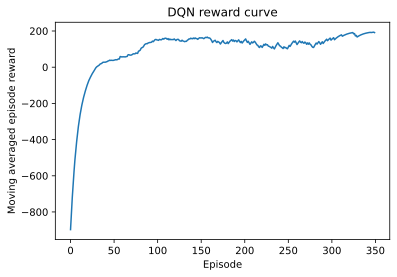

In [49]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    main(environment, 1.5)

Ep 0 Average score: -898.4 score of current env 16.0
Ep 1 Average score: -807.76 score of current env 8.0
Ep 2 Average score: -726.284 score of current env 7.0
Ep 3 Average score: -652.5556 score of current env 11.0
Ep 4 Average score: -584.7000400000001 score of current env 26.0
Ep 5 Average score: -525.230036 score of current env 10.0
Ep 6 Average score: -471.40703240000005 score of current env 13.0
Ep 7 Average score: -418.56632916000007 score of current env 57.0
Ep 8 Average score: -374.80969624400007 score of current env 19.0
Ep 9 Average score: -335.52872661960004 score of current env 18.0
Ep 10 Average score: -300.77585395764004 score of current env 12.0
Ep 11 Average score: -269.598268561876 score of current env 11.0
Ep 12 Average score: -241.8384417056884 score of current env 8.0
Ep 13 Average score: -216.85459753511955 score of current env 8.0
Ep 14 Average score: -194.36913778160758 score of current env 8.0
Ep 15 Average score: -173.13222400344682 score of current env 18.0
E

Ep 126 Average score: 77.95354908832658 score of current env 82.0
Ep 127 Average score: 78.15819417949393 score of current env 80.0
Ep 128 Average score: 78.54237476154455 score of current env 82.0
Ep 129 Average score: 78.4881372853901 score of current env 78.0
Ep 130 Average score: 77.93932355685108 score of current env 73.0
Ep 131 Average score: 77.74539120116597 score of current env 76.0
Ep 132 Average score: 77.57085208104937 score of current env 76.0
Ep 133 Average score: 76.91376687294442 score of current env 71.0
Ep 134 Average score: 76.02239018564998 score of current env 68.0
Ep 135 Average score: 76.32015116708499 score of current env 79.0
Ep 136 Average score: 78.2881360503765 score of current env 96.0
Ep 137 Average score: 77.55932244533884 score of current env 71.0
Ep 138 Average score: 78.20339020080496 score of current env 84.0
Ep 139 Average score: 79.78305118072447 score of current env 94.0
Ep 140 Average score: 81.10474606265203 score of current env 93.0
Ep 141 Avera

Ep 248 Average score: 191.81212862942087 score of current env 199.0
Ep 249 Average score: 192.53091576647878 score of current env 199.0
Ep 250 Average score: 193.17782418983091 score of current env 199.0
Ep 251 Average score: 187.96004177084782 score of current env 141.0
Ep 252 Average score: 186.96403759376307 score of current env 178.0
Ep 253 Average score: 174.16763383438678 score of current env 59.0
Ep 254 Average score: 161.2508704509481 score of current env 45.0
Ep 255 Average score: 165.0257834058533 score of current env 199.0
Ep 256 Average score: 168.42320506526798 score of current env 199.0
Ep 257 Average score: 171.4808845587412 score of current env 199.0
Ep 258 Average score: 164.3327961028671 score of current env 100.0
Ep 259 Average score: 167.79951649258038 score of current env 199.0
Ep 260 Average score: 170.91956484332235 score of current env 199.0
Ep 261 Average score: 171.32760835899012 score of current env 175.0
Ep 262 Average score: 174.09484752309112 score of curr

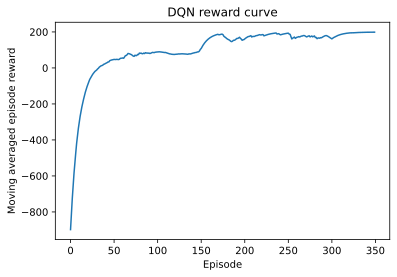

In [50]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    main(environment, 0.3)

Ep 0 Average score: -899.1 score of current env 9.0
Ep 1 Average score: -808.3900000000001 score of current env 8.0
Ep 2 Average score: -726.5510000000002 score of current env 10.0
Ep 3 Average score: -652.9959000000002 score of current env 9.0
Ep 4 Average score: -587.1963100000003 score of current env 5.0
Ep 5 Average score: -527.8766790000002 score of current env 6.0
Ep 6 Average score: -474.6890111000002 score of current env 4.0
Ep 7 Average score: -426.7201099900002 score of current env 5.0
Ep 8 Average score: -383.1480989910002 score of current env 9.0
Ep 9 Average score: -344.2332890919002 score of current env 6.0


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -307.5099601827102 score of current env 23.0
Ep 11 Average score: -276.0589641644392 score of current env 7.0
Ep 12 Average score: -247.95306774799528 score of current env 5.0
Ep 13 Average score: -222.25776097319576 score of current env 9.0
Ep 14 Average score: -199.0319848758762 score of current env 10.0
Ep 15 Average score: -177.4287863882886 score of current env 17.0
Ep 16 Average score: -155.78590774945974 score of current env 39.0
Ep 17 Average score: -138.90731697451375 score of current env 13.0
Ep 18 Average score: -122.91658527706238 score of current env 21.0
Ep 19 Average score: -107.02492674935615 score of current env 36.0
Ep 20 Average score: -94.22243407442055 score of current env 21.0
Ep 21 Average score: -79.7001906669785 score of current env 51.0
Ep 22 Average score: -67.93017160028066 score of current env 38.0
Ep 23 Average score: -56.737154440252596 score of current env 44.0
Ep 24 Average score: -48.56343899622734 score of current env 25.0
Ep 25 A

Ep 134 Average score: 128.68837427644937 score of current env 122.0
Ep 135 Average score: 129.61953684880444 score of current env 138.0
Ep 136 Average score: 130.65758316392402 score of current env 140.0
Ep 137 Average score: 131.29182484753161 score of current env 137.0
Ep 138 Average score: 130.06264236277846 score of current env 119.0
Ep 139 Average score: 129.1563781265006 score of current env 121.0
Ep 140 Average score: 128.54074031385056 score of current env 123.0
Ep 141 Average score: 129.68666628246552 score of current env 140.0
Ep 142 Average score: 129.91799965421896 score of current env 132.0
Ep 143 Average score: 130.62619968879707 score of current env 137.0
Ep 144 Average score: 132.16357971991738 score of current env 146.0
Ep 145 Average score: 130.74722174792564 score of current env 118.0
Ep 146 Average score: 131.4724995731331 score of current env 138.0
Ep 147 Average score: 130.7252496158198 score of current env 124.0
Ep 148 Average score: 130.5527246542378 score of cu

Ep 256 Average score: 177.1365278336081 score of current env 160.0
Ep 257 Average score: 177.32287505024732 score of current env 179.0
Ep 258 Average score: 171.0905875452226 score of current env 115.0
Ep 259 Average score: 171.78152879070035 score of current env 178.0
Ep 260 Average score: 172.1033759116303 score of current env 175.0
Ep 261 Average score: 171.89303832046727 score of current env 170.0
Ep 262 Average score: 172.90373448842053 score of current env 182.0
Ep 263 Average score: 173.81336103957847 score of current env 182.0
Ep 264 Average score: 173.73202493562064 score of current env 173.0
Ep 265 Average score: 173.1588224420586 score of current env 168.0
Ep 266 Average score: 171.84294019785276 score of current env 160.0
Ep 267 Average score: 171.65864617806747 score of current env 170.0
Ep 268 Average score: 173.69278156026076 score of current env 192.0
Ep 269 Average score: 173.92350340423468 score of current env 176.0
Ep 270 Average score: 173.1311530638112 score of cur

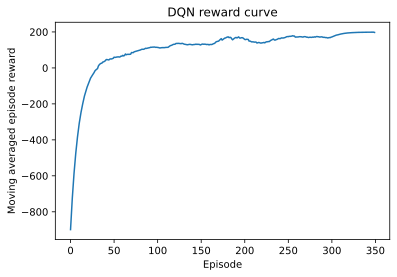

In [6]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    main(environment, 0.1)

Ep 0 Average score: -895.4 score of current env 46.0
Ep 1 Average score: -801.16 score of current env 47.0
Ep 2 Average score: -717.144 score of current env 39.0
Ep 3 Average score: -642.0296000000001 score of current env 34.0
Ep 4 Average score: -573.0266400000002 score of current env 48.0
Ep 5 Average score: -513.1239760000001 score of current env 26.0
Ep 6 Average score: -456.1115784000001 score of current env 57.0
Ep 7 Average score: -407.9004205600001 score of current env 26.0
Ep 8 Average score: -364.2103785040001 score of current env 29.0
Ep 9 Average score: -325.38934065360013 score of current env 24.0
Ep 10 Average score: -289.5504065882401 score of current env 33.0
Ep 11 Average score: -258.0953659294161 score of current env 25.0
Ep 12 Average score: -230.08582933647452 score of current env 22.0
Ep 13 Average score: -203.37724640282707 score of current env 37.0
Ep 14 Average score: -179.53952176254435 score of current env 35.0
Ep 15 Average score: -157.38556958628993 score of

Ep 125 Average score: 188.76983668672136 score of current env 199.0
Ep 126 Average score: 189.79285301804924 score of current env 199.0
Ep 127 Average score: 190.71356771624434 score of current env 199.0
Ep 128 Average score: 191.5422109446199 score of current env 199.0
Ep 129 Average score: 186.18798985015795 score of current env 138.0
Ep 130 Average score: 187.46919086514217 score of current env 199.0
Ep 131 Average score: 188.62227177862795 score of current env 199.0
Ep 132 Average score: 189.66004460076516 score of current env 199.0
Ep 133 Average score: 190.59404014068866 score of current env 199.0
Ep 134 Average score: 187.6346361266198 score of current env 161.0
Ep 135 Average score: 188.77117251395782 score of current env 199.0
Ep 136 Average score: 189.79405526256204 score of current env 199.0
Ep 137 Average score: 188.11464973630586 score of current env 173.0
Ep 138 Average score: 189.20318476267528 score of current env 199.0
Ep 139 Average score: 190.18286628640777 score of 

Ep 247 Average score: 198.99782147118194 score of current env 199.0
Ep 248 Average score: 198.99803932406374 score of current env 199.0
Ep 249 Average score: 198.99823539165737 score of current env 199.0
Ep 250 Average score: 198.99841185249164 score of current env 199.0
Ep 251 Average score: 198.9985706672425 score of current env 199.0
Ep 252 Average score: 198.99871360051824 score of current env 199.0
Ep 253 Average score: 198.99884224046642 score of current env 199.0
Ep 254 Average score: 198.99895801641978 score of current env 199.0
Ep 255 Average score: 198.9990622147778 score of current env 199.0
Ep 256 Average score: 198.99915599330004 score of current env 199.0
Ep 257 Average score: 198.99924039397004 score of current env 199.0
Ep 258 Average score: 198.99931635457304 score of current env 199.0
Ep 259 Average score: 198.99938471911574 score of current env 199.0
Ep 260 Average score: 198.99944624720416 score of current env 199.0
Ep 261 Average score: 198.99950162248376 score of 

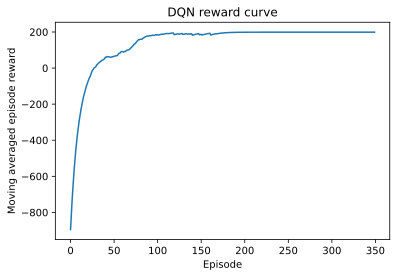

In [7]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    main(environment, 2)

### Save the expert trajectories

In [7]:
environment = 'CartPole-v0'

In [8]:
length = 1.2 
exp1 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_l%s_exp_states_%s.npy'%(length,environment))

In [9]:
length = 0.5
exp2 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_l%s_exp_states_%s.npy'%(length,environment))

In [10]:
length = 1.5
exp3 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_l%s_exp_states_%s.npy'%(length,environment))

In [11]:
length = 0.3
exp4 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_l%s_exp_states_%s.npy'%(length,environment))

In [12]:
length = 0.1
exp5 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_l%s_exp_states_%s.npy'%(length,environment))

In [13]:
length = 2
exp6 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_l%s_exp_states_%s.npy'%(length,environment))

Save the following :
- 5 expert trajectories as arrays within an array
- all with different length of pendulum
- none with length = 1 (default length for pendulum)

In [19]:
t1 = 'multi_diff_lengths_excl_1'

e = []
e.append(exp1)
e.append(exp6)
e.append(exp3)
e.append(exp4)
e.append(exp5)
e = np.asarray(e)
print(e.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t1,environment), e)

(5, 200, 4)


Save the following :

- 5 expert trajectories as arrays within an array
- all with same length of pendulum
- length is > 1 (default length for pendulum) --> here we take 1.5

In [14]:
t2 = 'multi_same_lengths_1_5'

f = []
f.append(exp3)
f.append(exp3)
f.append(exp3)
f.append(exp3)
f.append(exp3)
f = np.asarray(f)
print(f.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t2,environment), f)

(5, 200, 4)


In [17]:
t22 = 'multi_0_5'

f = []
f.append(exp2)
f.append(exp2)
f.append(exp2)
f.append(exp2)
f.append(exp2)
f = np.asarray(f)
print(f.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t22,environment), f)

(5, 200, 4)


In [18]:
t24 = 'multi_0_1'

f = []
f.append(exp5)
f.append(exp5)
f.append(exp5)
f.append(exp5)
f.append(exp5)
f = np.asarray(f)
print(f.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t24,environment), f)

(5, 200, 4)


Save the following :

- 5 expert trajectories as arrays within an array
- all with same length of pendulum
- length is < 1 (default length for pendulum) --> here we take 0.3

In [65]:
t3 = 'multi_same_lengths_0_3'

k = []
k.append(exp4)
k.append(exp4)
k.append(exp4)
k.append(exp4)
k.append(exp4)
k = np.asarray(k)
print(k.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t3,environment), k)

(5, 200, 4)


Save the following :

- 5 expert trajectories as arrays within an array
- all with same length of pendulum
- length is  1 (default length for pendulum) 

In [19]:
t4 = 'multi_same_lengths_1'

g = []
g.append(exp6)
g.append(exp6)
g.append(exp6)
g.append(exp6)
g.append(exp6)
g = np.asarray(g)
print(g.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t4,environment), g)

(5, 200, 4)


In [20]:
t26 = 'multi_1_2'

g = []
g.append(exp1)
g.append(exp1)
g.append(exp1)
g.append(exp1)
g.append(exp1)
g = np.asarray(g)
print(g.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t26,environment), g)

(5, 200, 4)


Save the following :

- 1 expert trajectory 
- length is 1 (default length for pendulum)

In [21]:
t5 = 'simple_length_1'

h = []
h.append(exp6)
h = np.asarray(h)
print(h.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t5,environment), h)

(1, 200, 4)


In [23]:
t23 = 'simple_0_5'

h = []
h.append(exp2)
h = np.asarray(h)
print(h.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t23,environment), h)

(1, 200, 4)


In [25]:
t25 = 'simple_0_1'

h = []
h.append(exp5)
h = np.asarray(h)
print(h.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t25,environment), h)

(1, 200, 4)


In [26]:
t27 = 'simple_1_2'

h = []
h.append(exp1)
h = np.asarray(h)
print(h.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t27,environment), h)

(1, 200, 4)


Save the following :

- 1 expert trajectory 
- length > 1 (default length for pendulum) --> here 1.5

In [68]:
t6 = 'simple_length_1_5'

j = []
j.append(exp3)
j = np.asarray(j)
print(j.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t6,environment), j)

(1, 200, 4)


Save the following :

- 1 expert trajectory 
- length < 1 (default length for pendulum) --> here 0.3

In [69]:
t7 = 'simple_length_0_3'

m = []
m.append(exp4)
m = np.asarray(m)
print(m.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t7,environment), m)

(1, 200, 4)


# Do the same as above but with changes in the mass of the cart

In [4]:
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

In [5]:
def main(environment, mass_cart):

    env = gym.make(environment)
    env.env.masscart = mass_cart 

    action_dim = env.action_space.n
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    agent = Agent(input_dim, output_dim, action_dim, environment)

    training_records = []
    running_reward, running_q = -1000, 0

    full_trajs = [] #supposed to be a list of arrays that will save several expert traj
    episodes = 350
    
    action_list = [i for i in range(action_dim)]
    
    for i_ep in tqdm(range(episodes)):
        score = 0
        
        #We fix the departure state 
#        state = env.reset()
#        env.env.state = np.array([np.pi/2, 0.5])
#        env.env.last_u = None
#        state = env.env._get_obs()
        
        #to make it more robust we have to use :
        #state = env.reset()
        
        state = env.reset()
        state = np.array([-6.18010447e+00, -5.22830905e+00,  7.34760972e+00,
         5.29961320e+00]) #fix the firs state
        
        
        
        full_traj = state.reshape(1,-1)
        for t in range(1, 200):
            action, action_index = agent.select_action(state)
            
            action = action_list[action_index]
            
            
            state_, reward, done, _ = env.step(action)
            full_traj = np.concatenate((full_traj, np.array(state_).reshape(1,-1)))
            score += reward

            env.render()
            agent.store_transition(Transition(state, action_index, (reward + 8) / 8, state_))
            state = state_
            if agent.memory.isfull:
                q = agent.update()
                running_q = 0.99 * running_q + 0.01 * q

        running_reward = running_reward * 0.9 + score * 0.1
        training_records.append(TrainingRecord(i_ep, running_reward))

        print('Ep', i_ep, 'Average score:', running_reward, 'score of current env', score )
        
        if i_ep > episodes - 3:
            full_trajs.append(full_traj)


    agent.save_param()
    #with open('/Users/ilanasebag/Documents/Thesis_Code/RL_results/dqn_training_records_%s_length%s.pkl'%(environment,length), 'wb') as f:
        #pickle.dump(training_records, f)
        
    save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/mc_%s_exp_states_%s.npy'%(mass_cart,environment),full_trajs[-1])       
    #save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_exp_states_%s.npy'%environment,full_trajs[-1])
    #save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/multi_exp_states_%s.npy'%environment,full_trajs)

    env.close()

    plt.plot([r.ep for r in training_records], [r.reward for r in training_records], color = 'grey')
    plt.xlabel('Episode')
    plt.ylabel('Moving averaged reward')
    plt.savefig("/Users/ilanasebag/Documents/Thesis_Code/RL_results/dqn_%s_masscart%s.png"%(environment,mass_cart))
    plt.show()


Ep 0 Average score: -898.6 score of current env 14.0
Ep 1 Average score: -805.54 score of current env 32.0
Ep 2 Average score: -723.986 score of current env 10.0
Ep 3 Average score: -647.6874 score of current env 39.0
Ep 4 Average score: -581.81866 score of current env 11.0
Ep 5 Average score: -522.536794 score of current env 11.0
Ep 6 Average score: -468.7831146 score of current env 15.0
Ep 7 Average score: -417.50480314000004 score of current env 44.0
Ep 8 Average score: -374.454322826 score of current env 13.0
Ep 9 Average score: -334.3088905434 score of current env 27.0
Ep 10 Average score: -297.47800148906003 score of current env 34.0
Ep 11 Average score: -266.23020134015405 score of current env 15.0
Ep 12 Average score: -237.60718120613865 score of current env 20.0
Ep 13 Average score: -211.94646308552478 score of current env 19.0
Ep 14 Average score: -188.05181677697232 score of current env 27.0
Ep 15 Average score: -166.44663509927508 score of current env 28.0
Ep 16 Average sco

Ep 125 Average score: 175.04630183926218 score of current env 199.0
Ep 126 Average score: 177.44167165533597 score of current env 199.0
Ep 127 Average score: 179.5975044898024 score of current env 199.0
Ep 128 Average score: 181.53775404082216 score of current env 199.0
Ep 129 Average score: 183.28397863673996 score of current env 199.0
Ep 130 Average score: 184.85558077306598 score of current env 199.0
Ep 131 Average score: 186.2700226957594 score of current env 199.0
Ep 132 Average score: 187.54302042618346 score of current env 199.0
Ep 133 Average score: 188.68871838356512 score of current env 199.0
Ep 134 Average score: 189.7198465452086 score of current env 199.0
Ep 135 Average score: 189.64786189068775 score of current env 189.0
Ep 136 Average score: 190.08307570161898 score of current env 194.0
Ep 137 Average score: 182.8747681314571 score of current env 118.0
Ep 138 Average score: 178.0872913183114 score of current env 135.0
Ep 139 Average score: 172.47856218648025 score of cur

Ep 247 Average score: 197.9442548482835 score of current env 199.0
Ep 248 Average score: 198.04982936345516 score of current env 199.0
Ep 249 Average score: 198.14484642710966 score of current env 199.0
Ep 250 Average score: 198.2303617843987 score of current env 199.0
Ep 251 Average score: 198.30732560595882 score of current env 199.0
Ep 252 Average score: 198.37659304536294 score of current env 199.0
Ep 253 Average score: 198.43893374082666 score of current env 199.0
Ep 254 Average score: 198.495040366744 score of current env 199.0
Ep 255 Average score: 198.5455363300696 score of current env 199.0
Ep 256 Average score: 198.59098269706266 score of current env 199.0
Ep 257 Average score: 198.6318844273564 score of current env 199.0
Ep 258 Average score: 198.66869598462077 score of current env 199.0
Ep 259 Average score: 198.7018263861587 score of current env 199.0
Ep 260 Average score: 198.73164374754285 score of current env 199.0
Ep 261 Average score: 198.75847937278857 score of curre

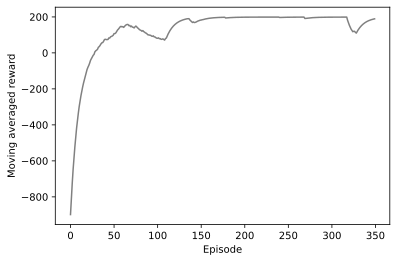

In [18]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    main(environment, env.env.masscart)

Ep 0 Average score: -897.8 score of current env 22.0
Ep 1 Average score: -805.12 score of current env 29.0
Ep 2 Average score: -723.1080000000001 score of current env 15.0
Ep 3 Average score: -648.7972000000001 score of current env 20.0
Ep 4 Average score: -582.5174800000001 score of current env 14.0
Ep 5 Average score: -520.2657320000001 score of current env 40.0
Ep 6 Average score: -467.0391588000001 score of current env 12.0
Ep 7 Average score: -418.1352429200001 score of current env 22.0
Ep 8 Average score: -374.1217186280001 score of current env 22.0
Ep 9 Average score: -334.30954676520014 score of current env 24.0
Ep 10 Average score: -296.87859208868014 score of current env 40.0
Ep 11 Average score: -266.0907328798121 score of current env 11.0
Ep 12 Average score: -238.4816595918309 score of current env 10.0
Ep 13 Average score: -212.1334936326478 score of current env 25.0
Ep 14 Average score: -189.32014426938304 score of current env 16.0
Ep 15 Average score: -167.98812984244472

Ep 124 Average score: 175.51088934302012 score of current env 199.0
Ep 125 Average score: 177.85980040871812 score of current env 199.0
Ep 126 Average score: 177.0738203678463 score of current env 170.0
Ep 127 Average score: 179.2664383310617 score of current env 199.0
Ep 128 Average score: 181.23979449795553 score of current env 199.0
Ep 129 Average score: 179.91581504816 score of current env 168.0
Ep 130 Average score: 173.824233543344 score of current env 119.0
Ep 131 Average score: 169.1418101890096 score of current env 127.0
Ep 132 Average score: 162.12762917010863 score of current env 99.0
Ep 133 Average score: 157.11486625309777 score of current env 112.0
Ep 134 Average score: 153.903379627788 score of current env 125.0
Ep 135 Average score: 150.81304166500922 score of current env 123.0
Ep 136 Average score: 150.8317374985083 score of current env 151.0
Ep 137 Average score: 155.64856374865747 score of current env 199.0
Ep 138 Average score: 159.98370737379173 score of current en

Ep 246 Average score: 198.99952945011995 score of current env 199.0
Ep 247 Average score: 198.99957650510797 score of current env 199.0
Ep 248 Average score: 198.99961885459717 score of current env 199.0
Ep 249 Average score: 198.99965696913748 score of current env 199.0
Ep 250 Average score: 198.99969127222374 score of current env 199.0
Ep 251 Average score: 198.99972214500139 score of current env 199.0
Ep 252 Average score: 198.99974993050125 score of current env 199.0
Ep 253 Average score: 198.99977493745115 score of current env 199.0
Ep 254 Average score: 198.99979744370606 score of current env 199.0
Ep 255 Average score: 198.99981769933547 score of current env 199.0
Ep 256 Average score: 198.99983592940194 score of current env 199.0
Ep 257 Average score: 198.99985233646174 score of current env 199.0
Ep 258 Average score: 198.99986710281559 score of current env 199.0
Ep 259 Average score: 198.99988039253404 score of current env 199.0
Ep 260 Average score: 198.99989235328064 score o

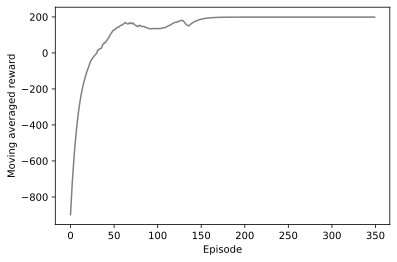

In [20]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    main(environment, 0.5)

Ep 0 Average score: -898.9 score of current env 11.0
Ep 1 Average score: -806.41 score of current env 26.0
Ep 2 Average score: -723.869 score of current env 19.0
Ep 3 Average score: -649.6821000000001 score of current env 18.0
Ep 4 Average score: -583.7138900000001 score of current env 10.0
Ep 5 Average score: -523.9425010000001 score of current env 14.0
Ep 6 Average score: -470.3482509000001 score of current env 12.0
Ep 7 Average score: -418.81342581000007 score of current env 45.0
Ep 8 Average score: -371.43208322900006 score of current env 55.0
Ep 9 Average score: -332.4888749061 score of current env 18.0
Ep 10 Average score: -297.93998741549 score of current env 13.0
Ep 11 Average score: -266.845988673941 score of current env 13.0
Ep 12 Average score: -238.96138980654692 score of current env 12.0
Ep 13 Average score: -211.46525082589224 score of current env 36.0
Ep 14 Average score: -186.418725743303 score of current env 39.0
Ep 15 Average score: -163.07685316897272 score of curren

Ep 125 Average score: 119.71298133792955 score of current env 66.0
Ep 126 Average score: 113.54168320413659 score of current env 58.0
Ep 127 Average score: 116.18751488372293 score of current env 140.0
Ep 128 Average score: 108.26876339535063 score of current env 37.0
Ep 129 Average score: 112.34188705581558 score of current env 149.0
Ep 130 Average score: 107.70769835023401 score of current env 66.0
Ep 131 Average score: 101.23692851521061 score of current env 43.0
Ep 132 Average score: 100.31323566368955 score of current env 92.0
Ep 133 Average score: 105.2819120973206 score of current env 150.0
Ep 134 Average score: 98.15372088758855 score of current env 34.0
Ep 135 Average score: 101.7383487988297 score of current env 134.0
Ep 136 Average score: 102.76451391894673 score of current env 112.0
Ep 137 Average score: 105.28806252705206 score of current env 128.0
Ep 138 Average score: 107.55925627434685 score of current env 128.0
Ep 139 Average score: 99.50333064691218 score of current e

Ep 247 Average score: 193.15774448737702 score of current env 199.0
Ep 248 Average score: 193.74197003863932 score of current env 199.0
Ep 249 Average score: 194.2677730347754 score of current env 199.0
Ep 250 Average score: 194.74099573129786 score of current env 199.0
Ep 251 Average score: 195.16689615816807 score of current env 199.0
Ep 252 Average score: 195.55020654235128 score of current env 199.0
Ep 253 Average score: 195.89518588811615 score of current env 199.0
Ep 254 Average score: 196.20566729930454 score of current env 199.0
Ep 255 Average score: 196.48510056937408 score of current env 199.0
Ep 256 Average score: 196.7365905124367 score of current env 199.0
Ep 257 Average score: 196.96293146119302 score of current env 199.0
Ep 258 Average score: 197.16663831507373 score of current env 199.0
Ep 259 Average score: 197.34997448356637 score of current env 199.0
Ep 260 Average score: 197.51497703520974 score of current env 199.0
Ep 261 Average score: 197.66347933168876 score of 

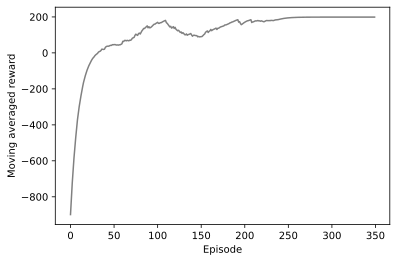

In [21]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    main(environment, 1.5)

Ep 0 Average score: -897.5 score of current env 25.0
Ep 1 Average score: -805.85 score of current env 19.0
Ep 2 Average score: -723.465 score of current env 18.0
Ep 3 Average score: -649.7185000000001 score of current env 14.0
Ep 4 Average score: -581.54665 score of current env 32.0
Ep 5 Average score: -521.791985 score of current env 16.0
Ep 6 Average score: -466.4127865 score of current env 32.0
Ep 7 Average score: -415.67150784999995 score of current env 41.0
Ep 8 Average score: -368.204357065 score of current env 59.0
Ep 9 Average score: -329.2839213585 score of current env 21.0
Ep 10 Average score: -294.45552922265 score of current env 19.0
Ep 11 Average score: -264.10997630038503 score of current env 9.0
Ep 12 Average score: -235.69897867034652 score of current env 20.0
Ep 13 Average score: -209.52908080331187 score of current env 26.0
Ep 14 Average score: -186.17617272298068 score of current env 24.0
Ep 15 Average score: -165.1585554506826 score of current env 24.0
Ep 16 Average

Ep 125 Average score: 148.7012190692467 score of current env 164.0
Ep 126 Average score: 151.13109716232205 score of current env 173.0
Ep 127 Average score: 150.21798744608984 score of current env 142.0
Ep 128 Average score: 152.29618870148084 score of current env 171.0
Ep 129 Average score: 153.86656983133278 score of current env 168.0
Ep 130 Average score: 153.47991284819952 score of current env 150.0
Ep 131 Average score: 155.73192156337956 score of current env 176.0
Ep 132 Average score: 156.05872940704162 score of current env 159.0
Ep 133 Average score: 159.15285646633745 score of current env 187.0
Ep 134 Average score: 158.03757081970372 score of current env 148.0
Ep 135 Average score: 159.53381373773337 score of current env 173.0
Ep 136 Average score: 161.18043236396002 score of current env 176.0
Ep 137 Average score: 160.262389127564 score of current env 152.0
Ep 138 Average score: 159.83615021480762 score of current env 156.0
Ep 139 Average score: 159.75253519332688 score of c

Ep 247 Average score: 161.2489314652421 score of current env 182.0
Ep 248 Average score: 165.02403831871788 score of current env 199.0
Ep 249 Average score: 157.8216344868461 score of current env 93.0
Ep 250 Average score: 161.9394710381615 score of current env 199.0
Ep 251 Average score: 165.64552393434536 score of current env 199.0
Ep 252 Average score: 158.78097154091083 score of current env 97.0
Ep 253 Average score: 150.30287438681975 score of current env 74.0
Ep 254 Average score: 140.77258694813779 score of current env 55.0
Ep 255 Average score: 134.595328253324 score of current env 79.0
Ep 256 Average score: 126.73579542799159 score of current env 56.0
Ep 257 Average score: 121.16221588519242 score of current env 71.0
Ep 258 Average score: 115.44599429667319 score of current env 64.0
Ep 259 Average score: 123.80139486700588 score of current env 199.0
Ep 260 Average score: 118.4212553803053 score of current env 70.0
Ep 261 Average score: 126.47912984227477 score of current env 1

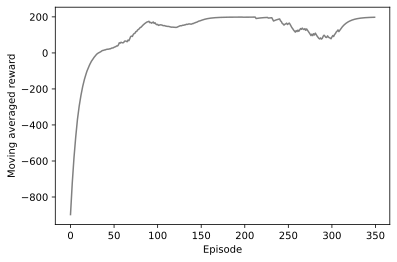

In [22]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    main(environment, 1.8)

Ep 0 Average score: -894.6 score of current env 54.0
Ep 1 Average score: -803.9399999999999 score of current env 12.0
Ep 2 Average score: -722.0459999999999 score of current env 15.0
Ep 3 Average score: -647.8413999999999 score of current env 20.0
Ep 4 Average score: -578.15726 score of current env 49.0
Ep 5 Average score: -517.141534 score of current env 32.0
Ep 6 Average score: -463.6273806 score of current env 18.0
Ep 7 Average score: -415.96464254 score of current env 13.0
Ep 8 Average score: -372.968178286 score of current env 14.0
Ep 9 Average score: -333.6713604574 score of current env 20.0
Ep 10 Average score: -296.60422441166 score of current env 37.0
Ep 11 Average score: -265.943801970494 score of current env 10.0
Ep 12 Average score: -237.64942177344463 score of current env 17.0
Ep 13 Average score: -210.78447959610017 score of current env 31.0
Ep 14 Average score: -187.10603163649017 score of current env 26.0
Ep 15 Average score: -165.09542847284115 score of current env 33.

Ep 126 Average score: 49.80402237796978 score of current env 120.0
Ep 127 Average score: 59.7236201401728 score of current env 149.0
Ep 128 Average score: 65.35125812615553 score of current env 116.0
Ep 129 Average score: 63.51613231353998 score of current env 47.0
Ep 130 Average score: 60.66451908218598 score of current env 35.0
Ep 131 Average score: 57.59806717396739 score of current env 30.0
Ep 132 Average score: 62.43826045657065 score of current env 106.0
Ep 133 Average score: 57.69443441091359 score of current env 15.0
Ep 134 Average score: 54.22499096982223 score of current env 23.0
Ep 135 Average score: 52.50249187284001 score of current env 37.0
Ep 136 Average score: 56.952242685556016 score of current env 97.0
Ep 137 Average score: 62.55701841700042 score of current env 113.0
Ep 138 Average score: 58.001316575300386 score of current env 17.0
Ep 139 Average score: 65.60118491777035 score of current env 134.0
Ep 140 Average score: 71.14106642599333 score of current env 121.0
Ep

Ep 248 Average score: 148.59811420670425 score of current env 23.0
Ep 249 Average score: 141.03830278603385 score of current env 73.0
Ep 250 Average score: 146.83447250743046 score of current env 199.0
Ep 251 Average score: 152.05102525668744 score of current env 199.0
Ep 252 Average score: 156.7459227310187 score of current env 199.0
Ep 253 Average score: 144.97133045791685 score of current env 39.0
Ep 254 Average score: 150.37419741212517 score of current env 199.0
Ep 255 Average score: 155.23677767091266 score of current env 199.0
Ep 256 Average score: 146.31309990382138 score of current env 66.0
Ep 257 Average score: 151.58178991343925 score of current env 199.0
Ep 258 Average score: 139.52361092209532 score of current env 31.0
Ep 259 Average score: 127.47124982988579 score of current env 19.0
Ep 260 Average score: 134.62412484689722 score of current env 199.0
Ep 261 Average score: 141.0617123622075 score of current env 199.0
Ep 262 Average score: 129.45554112598674 score of curren

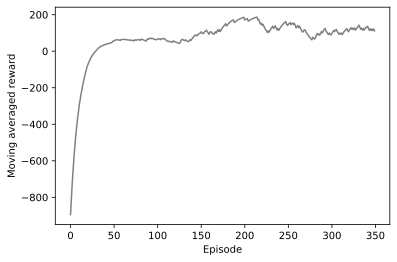

In [23]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    main(environment, 0.3)

Ep 0 Average score: -898.5 score of current env 15.0
Ep 1 Average score: -806.65 score of current env 20.0
Ep 2 Average score: -724.1850000000001 score of current env 18.0
Ep 3 Average score: -649.0665 score of current env 27.0
Ep 4 Average score: -582.45985 score of current env 17.0
Ep 5 Average score: -522.413865 score of current env 18.0
Ep 6 Average score: -468.77247850000003 score of current env 14.0
Ep 7 Average score: -416.39523065000003 score of current env 55.0
Ep 8 Average score: -372.05570758500005 score of current env 27.0
Ep 9 Average score: -333.15013682650005 score of current env 17.0
Ep 10 Average score: -296.23512314385005 score of current env 36.0
Ep 11 Average score: -265.31161082946505 score of current env 13.0
Ep 12 Average score: -237.78044974651854 score of current env 10.0
Ep 13 Average score: -212.00240477186668 score of current env 20.0
Ep 14 Average score: -187.20216429468002 score of current env 36.0
Ep 15 Average score: -165.48194786521202 score of current 

Ep 125 Average score: 174.25324145754277 score of current env 199.0
Ep 126 Average score: 171.2279173117885 score of current env 144.0
Ep 127 Average score: 168.90512558060968 score of current env 148.0
Ep 128 Average score: 165.7146130225487 score of current env 137.0
Ep 129 Average score: 169.04315172029382 score of current env 199.0
Ep 130 Average score: 172.03883654826444 score of current env 199.0
Ep 131 Average score: 169.934952893438 score of current env 151.0
Ep 132 Average score: 170.24145760409422 score of current env 173.0
Ep 133 Average score: 168.3173118436848 score of current env 151.0
Ep 134 Average score: 169.48558065931633 score of current env 180.0
Ep 135 Average score: 170.0370225933847 score of current env 175.0
Ep 136 Average score: 172.93332033404624 score of current env 199.0
Ep 137 Average score: 175.2399883006416 score of current env 196.0
Ep 138 Average score: 177.31598947057745 score of current env 196.0
Ep 139 Average score: 179.48439052351972 score of curre

Ep 247 Average score: 194.6720014198182 score of current env 199.0
Ep 248 Average score: 195.1048012778364 score of current env 199.0
Ep 249 Average score: 195.49432115005277 score of current env 199.0
Ep 250 Average score: 195.84488903504752 score of current env 199.0
Ep 251 Average score: 196.1604001315428 score of current env 199.0
Ep 252 Average score: 196.44436011838852 score of current env 199.0
Ep 253 Average score: 196.69992410654967 score of current env 199.0
Ep 254 Average score: 196.9299316958947 score of current env 199.0
Ep 255 Average score: 197.13693852630524 score of current env 199.0
Ep 256 Average score: 197.32324467367474 score of current env 199.0
Ep 257 Average score: 197.49092020630727 score of current env 199.0
Ep 258 Average score: 197.64182818567656 score of current env 199.0
Ep 259 Average score: 197.7776453671089 score of current env 199.0
Ep 260 Average score: 197.89988083039802 score of current env 199.0
Ep 261 Average score: 198.00989274735824 score of cur

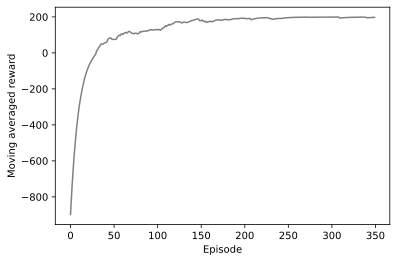

In [7]:
if __name__ == '__main__':
    environment = 'CartPole-v0'
    main(environment, 2.1)

In [16]:
environment = 'CartPole-v0'
env = gym.make(environment )

In [17]:
mass_cart = env.env.masscart
m_1 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/mc_%s_exp_states_%s.npy'%(mass_cart,environment))

In [18]:
mass_cart = 2.1
m_21 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/mc_%s_exp_states_%s.npy'%(mass_cart,environment))

In [19]:
mass_cart = 0.5
m_05 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/mc_%s_exp_states_%s.npy'%(mass_cart,environment))

In [20]:
mass_cart = 1.5
m_15 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/mc_%s_exp_states_%s.npy'%(mass_cart,environment))

In [21]:
mass_cart = 1.8
m_18 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/mc_%s_exp_states_%s.npy'%(mass_cart,environment))

In [22]:
mass_cart = 0.3
m_03 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/mc_%s_exp_states_%s.npy'%(mass_cart,environment))

In [23]:
trajectory_m = 'multiple_mass'

f = []
f.append(m_21)
f.append(m_05)
f.append(m_18)
f.append(m_15)
f.append(m_03)
f = np.asarray(f)
print(f.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(trajectory_m,environment), f)

(5, 200, 4)
